# Предварительная настройка

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn import metrics
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import sys
import copy
import random
import json

In [4]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

# Датасет

**image loaders** https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**data loaders** https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
NAME='Fires'

NAME='Fast Food Classification V2'

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(30),  # Поворот изображений на случайный угол до 30 градусов
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/My Drive/AI/Samsung/'+NAME

data_dir = './'+NAME
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


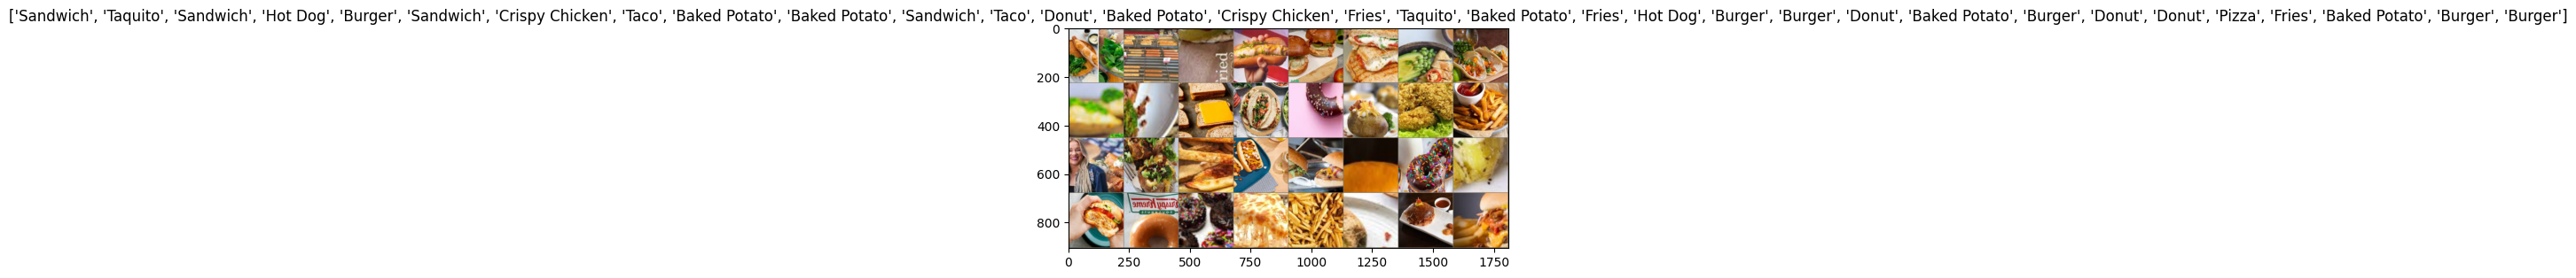

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
len(dataloaders['val'])

110

In [ ]:
len(dataloaders['train'])

469

In [ ]:
class_names
# for inputs, labels in dataloaders['train']:
#      print(labels)

['Baked Potato',
 'Burger',
 'Crispy Chicken',
 'Donut',
 'Fries',
 'Hot Dog',
 'Pizza',
 'Sandwich',
 'Taco',
 'Taquito']

In [ ]:
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = [];
    hist_loss_val = []; hist_acc_val = []
    hist_f1 = []
    plt.ion()  # Включение интерактивного режима для обновления графика

    fig, ax = plt.subplots(1,2)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss')
    # ax[0].legend(framealpha=1, frameon=True)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc')
    ax[1].set_title('Training Acc')
    # ax[1].legend(framealpha=1, frameon=True)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            if phase == 'train':
                scheduler.step()
                # scheduler.step(epoch_loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc.cpu().numpy())
            else:
                hist_loss_val.append(epoch_loss)
                hist_acc_val.append(epoch_acc.cpu().numpy())

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        plt.ioff()  # Выключение интерактивного режима
        plt.show()
        ax[0].plot(np.arange(0, epoch + 1), hist_loss_train, label='hist_loss_train')
        # ax[0].plot(np.arange(0, epoch + 1), hist_loss_val, label='hist_loss_val')
        # ax[1].plot(np.arange(0, epoch + 1), hist_acc_train, label='hist_acc_train')
        # ax[1].plot(np.arange(0, epoch + 1), hist_acc_val, label='hist_acc_val')
        plt.pause(0.1)  # Пауза для обновления графика

        # # Update plots
        # plt.figure(1)
        # plt.clf()
        # plt.plot(np.arange(0, epoch + 1), hist_loss_train, label='hist_loss_train')
        # plt.plot(np.arange(0, epoch + 1), hist_loss_val, label='hist_loss_val')
        # plt.legend(framealpha=1, frameon=True)
        # plt.title('Loss')
        # plt.pause(0.001)  # Pause to update the figure

        # plt.figure(2)
        # plt.clf()
        # plt.plot(np.arange(0, epoch + 1), hist_acc_train, label='hist_acc_train')
        # plt.plot(np.arange(0, epoch + 1), hist_acc_val, label='hist_acc_val')
        # plt.legend(framealpha=1, frameon=True)
        # plt.title('Acc')
        # plt.pause(0.001)  # Pause to update the figure

    model.eval()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best epoch:{} val Loss:{:4f} Acc: {:4f}'.format(best_epoch,best_loss,best_acc))

    plt.plot(np.arange(0,num_epochs),hist_loss_train,label='hist_loss_train')
    plt.plot(np.arange(0,num_epochs),hist_loss_val,label='hist_loss_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Loss')
    plt.show()
    plt.plot(np.arange(0,num_epochs),hist_acc_train,label='hist_acc_train')
    plt.plot(np.arange(0,num_epochs),hist_acc_val,label='hist_acc_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Acc')
    plt.show()


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            t0 = time.time()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print("Время инфренса батча(мс): {:4f}".format((time.time()-t0)*1000))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
  param.requires_grad = False
num_ftrs = model_ft.fc.in_features
# !!!!!!!!!!!!!!!!!!!!!!!!! Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)
# Определение нового выходного слоя с дополнительным скрытым слоем
# model_ft.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 256),  # Новый скрытый слой
#     nn.ReLU(),                 # Функция активации=
#     nn.Linear(256, 10)         # Исходный выходной слой
# )

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0008, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, mode='min', factor=0.1, patience=5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.4473 Acc: 0.5570
val Loss: 1.0108 Acc: 0.6963


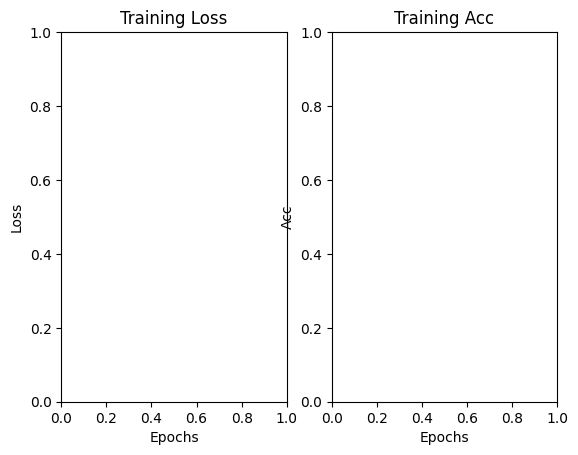

Epoch 1/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.0231 Acc: 0.6909
val Loss: 0.8920 Acc: 0.7263
Epoch 2/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.9361 Acc: 0.7103
val Loss: 0.8335 Acc: 0.7437
Epoch 3/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.9032 Acc: 0.7155
val Loss: 0.8469 Acc: 0.7377
Epoch 4/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8820 Acc: 0.7169
val Loss: 0.8388 Acc: 0.7426
Epoch 5/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8704 Acc: 0.7206
val Loss: 0.8244 Acc: 0.7391
Epoch 6/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8635 Acc: 0.7241
val Loss: 0.8300 Acc: 0.7443
Epoch 7/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8347 Acc: 0.7353
val Loss: 0.8076 Acc: 0.7503
Epoch 8/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8426 Acc: 0.7323
val Loss: 0.7972 Acc: 0.7531
Epoch 9/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8361 Acc: 0.7348
val Loss: 0.8100 Acc: 0.7506
Epoch 10/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8361 Acc: 0.7315
val Loss: 0.8037 Acc: 0.7500
Epoch 11/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8332 Acc: 0.7385
val Loss: 0.8153 Acc: 0.7460
Epoch 12/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8351 Acc: 0.7334
val Loss: 0.8071 Acc: 0.7494
Epoch 13/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8406 Acc: 0.7351
val Loss: 0.7999 Acc: 0.7534
Epoch 14/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8228 Acc: 0.7420
val Loss: 0.8049 Acc: 0.7537
Epoch 15/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8267 Acc: 0.7364
val Loss: 0.8030 Acc: 0.7517
Epoch 16/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8408 Acc: 0.7296
val Loss: 0.8015 Acc: 0.7517
Epoch 17/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8297 Acc: 0.7363
val Loss: 0.8060 Acc: 0.7486
Epoch 18/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8325 Acc: 0.7322
val Loss: 0.8135 Acc: 0.7494
Epoch 19/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8299 Acc: 0.7343
val Loss: 0.8107 Acc: 0.7451
Epoch 20/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8350 Acc: 0.7341
val Loss: 0.8089 Acc: 0.7503
Epoch 21/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8384 Acc: 0.7321
val Loss: 0.8023 Acc: 0.7529
Epoch 22/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8416 Acc: 0.7305
val Loss: 0.8002 Acc: 0.7506
Epoch 23/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8356 Acc: 0.7372
val Loss: 0.8028 Acc: 0.7520
Epoch 24/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8221 Acc: 0.7382
val Loss: 0.8056 Acc: 0.7520
Epoch 25/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8341 Acc: 0.7316
val Loss: 0.8073 Acc: 0.7517
Epoch 26/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8277 Acc: 0.7383
val Loss: 0.8117 Acc: 0.7480
Epoch 27/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8311 Acc: 0.7406
val Loss: 0.8056 Acc: 0.7506
Epoch 28/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8325 Acc: 0.7357
val Loss: 0.8020 Acc: 0.7503
Epoch 29/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8392 Acc: 0.7319
val Loss: 0.7883 Acc: 0.7580
Epoch 30/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8355 Acc: 0.7359
val Loss: 0.7963 Acc: 0.7534
Epoch 31/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8194 Acc: 0.7394
val Loss: 0.8111 Acc: 0.7486
Epoch 32/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8274 Acc: 0.7344
val Loss: 0.7947 Acc: 0.7517
Epoch 33/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8385 Acc: 0.7387
val Loss: 0.8000 Acc: 0.7540
Epoch 34/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8241 Acc: 0.7395
val Loss: 0.7927 Acc: 0.7566
Epoch 35/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8281 Acc: 0.7385
val Loss: 0.8056 Acc: 0.7511
Epoch 36/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8166 Acc: 0.7427
val Loss: 0.8079 Acc: 0.7469
Epoch 37/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8300 Acc: 0.7385
val Loss: 0.8176 Acc: 0.7477
Epoch 38/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8369 Acc: 0.7329
val Loss: 0.8209 Acc: 0.7446
Epoch 39/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8344 Acc: 0.7332
val Loss: 0.8005 Acc: 0.7503
Epoch 40/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8264 Acc: 0.7397
val Loss: 0.8001 Acc: 0.7523
Epoch 41/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8255 Acc: 0.7359
val Loss: 0.8112 Acc: 0.7466
Epoch 42/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8458 Acc: 0.7294
val Loss: 0.8076 Acc: 0.7494
Epoch 43/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8258 Acc: 0.7385
val Loss: 0.7906 Acc: 0.7546
Epoch 44/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8210 Acc: 0.7393
val Loss: 0.8190 Acc: 0.7443
Epoch 45/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8338 Acc: 0.7327
val Loss: 0.8038 Acc: 0.7489
Epoch 46/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8286 Acc: 0.7383
val Loss: 0.7979 Acc: 0.7531
Epoch 47/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8280 Acc: 0.7363
val Loss: 0.7940 Acc: 0.7523
Epoch 48/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8287 Acc: 0.7416
val Loss: 0.8140 Acc: 0.7443
Epoch 49/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8429 Acc: 0.7317
val Loss: 0.7989 Acc: 0.7549
Epoch 50/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8234 Acc: 0.7391
val Loss: 0.7951 Acc: 0.7554
Epoch 51/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8324 Acc: 0.7343
val Loss: 0.8001 Acc: 0.7511
Epoch 52/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8282 Acc: 0.7381
val Loss: 0.7997 Acc: 0.7526
Epoch 53/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8226 Acc: 0.7395
val Loss: 0.8036 Acc: 0.7526
Epoch 54/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8273 Acc: 0.7365
val Loss: 0.8054 Acc: 0.7534
Epoch 55/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8324 Acc: 0.7365
val Loss: 0.8107 Acc: 0.7500
Epoch 56/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8444 Acc: 0.7339
val Loss: 0.8110 Acc: 0.7489
Epoch 57/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8237 Acc: 0.7385
val Loss: 0.8206 Acc: 0.7471
Epoch 58/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8335 Acc: 0.7341
val Loss: 0.8282 Acc: 0.7474
Epoch 59/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8329 Acc: 0.7372
val Loss: 0.8067 Acc: 0.7506
Epoch 60/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8320 Acc: 0.7343
val Loss: 0.8059 Acc: 0.7526
Epoch 61/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8395 Acc: 0.7365
val Loss: 0.7984 Acc: 0.7557
Epoch 62/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8279 Acc: 0.7387
val Loss: 0.7987 Acc: 0.7537
Epoch 63/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8302 Acc: 0.7382
val Loss: 0.8147 Acc: 0.7466
Epoch 64/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8305 Acc: 0.7351
val Loss: 0.8054 Acc: 0.7534
Epoch 65/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8350 Acc: 0.7311
val Loss: 0.8145 Acc: 0.7477
Epoch 66/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8367 Acc: 0.7365
val Loss: 0.8063 Acc: 0.7497
Epoch 67/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8407 Acc: 0.7319
val Loss: 0.8055 Acc: 0.7500
Epoch 68/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8244 Acc: 0.7420
val Loss: 0.8087 Acc: 0.7526
Epoch 69/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8388 Acc: 0.7359
val Loss: 0.8181 Acc: 0.7440
Epoch 70/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8276 Acc: 0.7351
val Loss: 0.8024 Acc: 0.7534
Epoch 71/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8333 Acc: 0.7355
val Loss: 0.8098 Acc: 0.7483
Epoch 72/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8417 Acc: 0.7326
val Loss: 0.8038 Acc: 0.7469
Epoch 73/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8342 Acc: 0.7370
val Loss: 0.8085 Acc: 0.7471
Epoch 74/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8377 Acc: 0.7355
val Loss: 0.8046 Acc: 0.7537
Epoch 75/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8173 Acc: 0.7417
val Loss: 0.8077 Acc: 0.7469
Epoch 76/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8291 Acc: 0.7366
val Loss: 0.8008 Acc: 0.7526
Epoch 77/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8268 Acc: 0.7387
val Loss: 0.7988 Acc: 0.7571
Epoch 78/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8388 Acc: 0.7345
val Loss: 0.8085 Acc: 0.7509
Epoch 79/79
----------


/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/drmr/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8347 Acc: 0.7358
val Loss: 0.7980 Acc: 0.7514
Training complete in 27m 13s
Best epoch:29 val Loss:0.788348 Acc: 0.758000


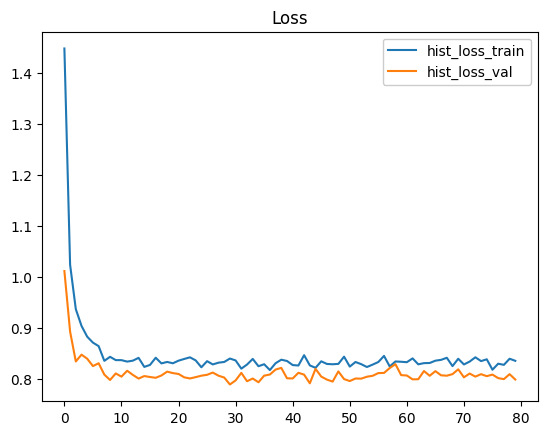

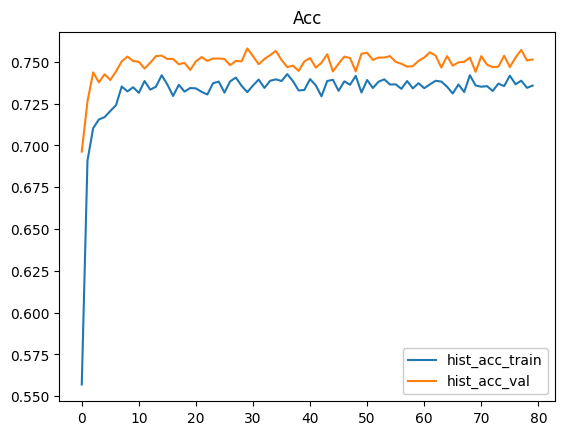

--- 1633.6212356090546 seconds ---


In [ ]:
import time
start_time = time.time()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=80)
print("--- %s seconds ---" % (time.time() - start_time))

Время инфренса батча(мс): 6.865978


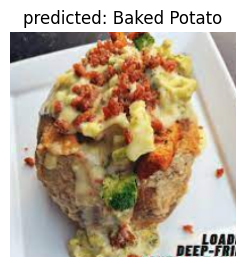

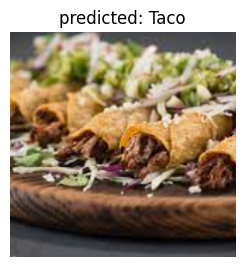

In [ ]:
visualize_model(model_ft.to(device),num_images=2)

In [ ]:
true_labels=[]
pred_labels=[]
for inputs, labels in dataloaders['val']:
  pred = model_ft.forward(inputs.to(device))
  _, pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
from pandas import DataFrame
import seaborn as sn
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

[[317   2  17   4   0   2  20   5  18  15]
 [  6 251   4   9   1   5   0  22   1   1]
 [ 16  14 336   2   5   0   6   8   8   5]
 [  2   6   2 277   0   3   2   1   4   3]
 [  3  19   6   6 305  17   3   5  23  13]
 [ 11  13  13   5  16 162   8  17  31  24]
 [ 14   1   7   1   3   2 246   6  10  10]
 [  7  18   4   4  16  10   5 200  22  14]
 [ 14   3   9   5   2  11   8   4 321  23]
 [ 16   3  15  13  10  20  13  17  55 238]]


In [ ]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model_ft.eval()
model_ft=model_ft.to(torch.device("cpu"))
#model_ft=torch.quantization.convert(model_ft)
#torch.jit.script(model_ft).save("/content/drive/My Drive/AI/Samsung/fire_net.pt")
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model_ft,input_tensor)
# script_model.save("/content/drive/My Drive/AI/Samsung/"+NAME+".pt")
script_model.save("./"+NAME+"_end3.pt")

In [ ]:
!nvidia-smi

Fri Jun 28 18:03:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:27:00.0  On |                  N/A |
|  0%   44C    P2              80W / 280W |   1044MiB / 11264MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Функция для предсказания и отображения одного изображения из папки 'test'
def predict_and_show_image(model, image_path, class_names, device):
    # Преобразование изображения
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Загрузка изображения
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Предсказание
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)

    # Отображение изображения с предсказанием
    plt.figure()
    print(preds)
    imshow(image_tensor.cpu().squeeze(), f'Predicted: {class_names[preds[0]]}')
    plt.show()

In [ ]:
# Загрузка классов из файла
with open('class_names.json', 'r') as f:
    class_names = json.load(f)

1 tensor([8]) [8]


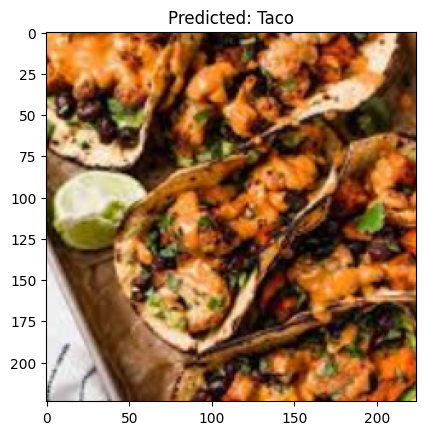

In [ ]:
model_path = f"./{NAME}_v3.pt"
model_ft = torch.jit.load(model_path)
model_ft.eval()
model_ft = model_ft.to(device)

# Задайте путь к изображению из папки 'test'
image_path = f'./{NAME}/test/Taco/Taco-Test (1).jpeg'

# Вызов функции для предсказания и отображения изображения
predict_and_show_image(model_ft, image_path, class_names, device)

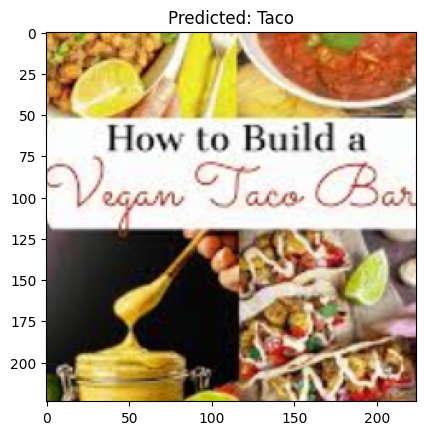

In [ ]:
# Задайте путь к изображению из папки 'test'
image_path = f'./{NAME}/test/Taco/Taco-Test (9).jpeg'

# Вызов функции для предсказания и отображения изображения
predict_and_show_image(model_ft, image_path, class_names, device)

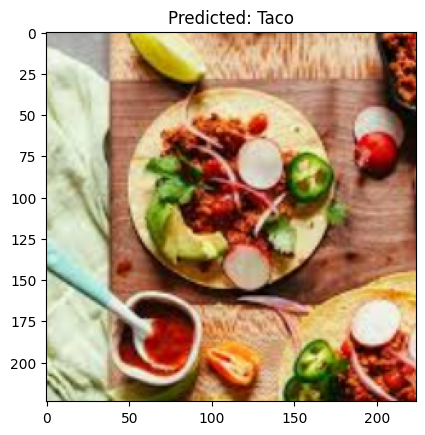

In [ ]:
# Задайте путь к изображению из папки 'test'
image_path = f'./{NAME}/test/Taco/Taco-Test (15).jpeg'

# Вызов функции для предсказания и отображения изображения
predict_and_show_image(model_ft, image_path, class_names, device)

# Телеграмм бот

In [ ]:
import json
import logging
import torch

from telegram import Update, ForceReply, ReplyKeyboardMarkup
from telegram.ext import Application, CommandHandler, MessageHandler, filters, ContextTypes

from PIL import Image
from torchvision import transforms

# Включите ведение журнала
logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO
)
logger = logging.getLogger(__name__)

# Словарь с русскими названиями классов
RUSSIAN_CLASS_NAMES = {
    "Baked Potato": "Печёная картошка",
    "Burger": "Бургер",
    "Crispy Chicken": "Хрустящая курочка",
    "Donut": "Пончик",
    "Fries": "Картофель фри",
    "Hot Dog": "Хот-дог",
    "Pizza": "Пицца",
    "Sandwich": "Сэндвич",
    "Taco": "Тако",
    "Taquito": "Бурито",
}
# Словарь с локализациями
LOCALES = {
    'ru': {
        'start': "Привет, {user}! Я бот для обработки картинок с едой. "
                 "Отправь мне картинку, и я скажу тебе, что на ней.",
        'image_received': "Крутая картинка! Я пока не умею анализировать изображения, но скоро научусь!",
        'language_set': "Язык изменен на русский.",
        'non_command_message': "Для использования бота отправьте изображение.",
        'choose_language': "Выберите язык:",
        'help': "Данный бот создан на основе BotFather. Используя машинное зрение и нейронные сети, "
                        "он способен определить вид еды по фото. Для получения результата достаточно отправить картинку боту.",
        'image_prediction': "На изображении, вероятно, {predicted_class}.",
        'image_processing_error': "Произошла ошибка при обработке изображения.",
        'send_jpeg_image': "Пожалуйста, отправьте изображение в формате JPEG."
    },
    'en': {
        'start': "Hi, {user}! I'm a bot for processing images of food. "
                 "Send me a picture, and I'll tell you what's on it.",
        'image_received': "Cool picture! I don't know how to analyze images yet, but I will soon!",
        'language_set': "Language changed to English.",
        'non_command_message': "To use the bot, please send an image.",
        'choose_language': "Choose your language:",
        'help': "This bot is built based on BotFather. Using computer vision and neural networks,"
                        " it can identify food types from photos. To get a result, simply send a picture to the bot.",
        'image_prediction': "The image probably shows {predicted_class}.",
        'image_processing_error': "An error occurred while processing the image.",
        'send_jpeg_image': "Please send an image in JPEG format."
    },
}

# Функция для получения локализованной строки
def get_locale_string(language_code: str, key: str, **kwargs) -> str:
    """Возвращает локализованную строку по ключу и языку."""
    return LOCALES.get(language_code, LOCALES['en']).get(key, '').format(**kwargs)


# Обработчик команды /start
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    """Отправляет приветственное сообщение при получении команды /start."""
    user = update.effective_user
    language_code = context.user_data.get('language_code', 'en')

    await update.message.reply_html(
        get_locale_string(language_code, 'start', user=user.mention_html()),
        reply_markup=ForceReply(selective=True),
    )

# Обработчик команды /help
async def help_command(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    """Отправляет сообщение с описанием бота."""
    language_code = context.user_data.get('language_code', 'en')
    await update.message.reply_text(get_locale_string(language_code, 'help'))

# Обработчик команды /changeLng
async def change_language(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    """Изменяет язык пользователя."""
    language_code = context.user_data.get('language_code', 'en')

    # Создаем клавиатуру с выбором языка
    keyboard = ReplyKeyboardMarkup(
        [['Русский', 'English']],
        resize_keyboard=True,
        one_time_keyboard=True,
    )

    await update.message.reply_text(
        get_locale_string(language_code, 'choose_language'),
        reply_markup=keyboard,
    )


# Обработчик выбора языка
async def set_language(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    """Устанавливает выбранный язык пользователя."""
    user_choice = update.message.text

    global class_names

    if user_choice == 'Русский':
        context.user_data['language_code'] = 'ru'
        response_text = get_locale_string('ru', 'language_set')
        class_names = [RUSSIAN_CLASS_NAMES.get(name, name) for name in class_names]
    else:
        context.user_data['language_code'] = 'en'
        response_text = get_locale_string('en', 'language_set')
        with open("class_names.json", 'r') as f:
            class_names = json.load(f)

    await update.message.reply_text(
        response_text,
        reply_markup=ReplyKeyboardMarkup([['/start']])
    )


# Функция для обработки изображения (вызывается и для фото, и для документов)
async def process_image(update: Update, context: ContextTypes.DEFAULT_TYPE, image_path: str) -> None:
    """Обрабатывает изображение и отправляет результат пользователю."""
    language_code = context.user_data.get('language_code', 'en')

    try:
        # Загружаем изображение с помощью PIL
        image = Image.open(image_path).convert("RGB")

        # Преобразование и предсказание
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            _, preds = torch.max(outputs, 1)

        predicted_class = class_names[preds[0]]

        await update.message.reply_text(
            get_locale_string(language_code, 'image_prediction', predicted_class=predicted_class),
            reply_to_message_id=update.message.message_id
        )


    except Exception as e:
        logger.error(f"Ошибка при обработке изображения: {e}")
        await update.message.reply_text(
            get_locale_string(language_code, 'image_processing_error')
        )

# Обработчик изображений
async def image_handler(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    """Обрабатывает отправленные изображения."""
    #language_code = context.user_data.get('language_code', 'en')

    file = await context.bot.get_file(update.message.photo[-1].file_id)
    image_path = "temp_image.jpg"
    await file.download_to_drive(image_path)
    await process_image(update, context, image_path)
# Обработчик документов (JPEG)
async def document_handler(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    """Обрабатывает JPEG, отправленные как документы."""
    language_code = context.user_data.get('language_code', 'en')

    if update.message.document.mime_type == 'image/jpeg':
        file = await context.bot.get_file(update.message.document.file_id)
        image_path = "temp_image.jpg"
        await file.download_to_drive(image_path)

        await process_image(update, context, image_path) # Вызываем функцию для обработки

    else:
        await update.message.reply_text(
            get_locale_string(language_code, 'send_jpeg_image')
        )
# Обработчик некомандных сообщений и изображений
async def non_command_handler(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    """Обрабатывает сообщения, не являющиеся командами."""
    language_code = context.user_data.get('language_code', 'en')
    await update.message.reply_text(get_locale_string(language_code, 'non_command_message'))

# Функция загрузки модели и имен классов
def load_model_and_classes(model_path="Fast_Food_Classification_V2_v2.pt",
                           class_names_path="class_names.json"):
    """Загружает модель и имена классов из файлов."""
    try:
        global model, class_names, device, preprocess

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = torch.load(model_path)
        model.to(device)

        # Преобразование изображения
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        with open(class_names_path, 'r') as f:
            class_names = json.load(f)
        return model, class_names
    except Exception as e:
        logger.error(f"Ошибка при загрузке модели или имен классов: {e}")
        return None, None
def main() -> None:
    """Запускает бота."""
    application = Application.builder().token("7387262541:AAHKzEGN5l-cRUqlwdlPBXpSHknQeztAd8g").build()

    model, class_names = load_model_and_classes()
    if model is None or class_names is None:
        logger.error("Не удалось загрузить модель или имена классов. Выход.")
        return

    application.add_handler(CommandHandler("start", start))
    application.add_handler(CommandHandler("help", help_command))
    application.add_handler(CommandHandler("change_lng", change_language))
    application.add_handler(MessageHandler(filters.TEXT & filters.Regex(r'^(Русский|English)$'), set_language))
    application.add_handler(MessageHandler(filters.PHOTO, image_handler))
    application.add_handler(MessageHandler(filters.Document.JPG, document_handler))

    application.add_handler(MessageHandler(~filters.COMMAND, non_command_handler))

    application.run_polling()


if __name__ == "__main__":
    main()